In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal
from scipy.optimize import curve_fit

From _Numerical Recipes_, ch. 15.2:
$$
S = \sum_{i=0}^{N-1} \frac{1}{\sigma_i^2}, 
S_x = \sum_{i=0}^{N-1} \frac{x_i}{\sigma_i^2}, 
S_y = \sum_{i=0}^{N-1} \frac{y_i}{\sigma_i^2}, 
S_{xx} = \sum_{i=0}^{N-1} \frac{x_i^2}{\sigma_i^2}, 
S_{xy} = \sum_{i=0}^{N-1} \frac{x_i y_i}{\sigma_i^2}
$$

$$
\Delta = S S_{xx} - \left( S_x \right)^2, 
a = \frac{S_{xx} S_y - S_x S_{xy}}{\Delta},
b = \frac{S S_{xy} - S_x S_y}{\Delta}
$$

$$
\sigma_a^2 = \frac{S_{xx}}{\Delta},
\sigma_b^2 = \frac{S}{\Delta}
$$

The velocity profile is given by
$$
u(z) = \frac{u_\star}{\kappa} \ln \left( \frac{z}{z_\star} \right)
$$
with $z_\star$ as the roughness scale (as opposed to the usual $z_0$).

Re-casting as a linear fit:$y_i = m x_i + b$ with $x_i = \ln \left( z_i / z_0 \right)$, $y_i = u(z_i)$, $m = u_\star/\kappa$, and $b = -\dfrac{u_\star}{\kappa} \ln \left( \dfrac{z_\star}{z_0} \right)$, where $z_0$ is the bottom anemometer height.

Assume logarithmic spacing, i.e. $\ln\left( z_i / z_0 \right) = i\ \delta x$.

In [19]:
def calc_S(sigma):
    return np.sum(1./sigma**2)

def calc_Sx(x, sigma):
    return np.sum(x/sigma**2)

def calc_Sxx(x, sigma):
    return np.sum(x**2/sigma**2)

def calc_Sy(y, sigma):
    return np.sum(y/sigma**2)

def calc_Syy(y, sigma):
    return np.sum(y**2/sigma**2)

def calc_Sxy(x, y, sigma):
    return np.sum(x*y/sigma**2)

def calc_Delta(x, sigma):
    S = calc_S(sigma)
    Sxx = calc_Sxx(x, sigma)
    Sx = calc_Sx(x, sigma)
    
    return S*Sxx - Sx**2

def calc_intercept(x, y, sigma):
    Sxx = calc_Sxx(x, sigma)
    Sy = calc_Sy(y, sigma)
    Sx = calc_Sx(x, sigma)
    Sxy = calc_Sxy(x, y, sigma)
    Delta = calc_Delta(x, sigma)
    
    return (Sxx*Sy - Sx*Sxy)/Delta

def calc_slope(x, y, sigma):
    S = calc_S(sigma)
    Sxy = calc_Sxy(x, y, sigma)
    Sx = calc_Sx(x, sigma)
    Sy = calc_Sy(y, sigma)
    Delta = calc_Delta(x, sigma)
    
    return (S*Sxy - Sx*Sy)/Delta

def sigma_intercept(x, sigma):
    Sxx = calc_Sxx(x, sigma)
    Delta = calc_Delta(x, sigma)
    
    return np.sqrt(Sxx/Delta)

def sigma_slope(x, sigma):
    S = calc_S(sigma)
    Delta = calc_Delta(x, sigma)
    
    return np.sqrt(S/Delta)

9.999325403777299 -2.700909049856492
0.7905694150420948 3.872983346207417
[ 9.99932542 -2.70090914]
[0.59972667 2.93804853]


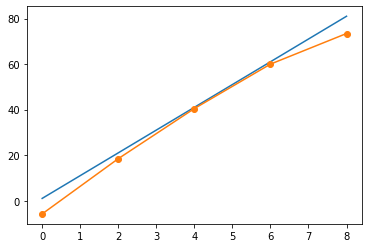

In [48]:
def lin_fit(x, m, b):
    return m*x + b

# Let's test these expressions
num_sensors = 5
delta_x = 2.
sigma = 5.*np.ones(num_sensors)
slope = 10.
intercept = 1.

x = np.arange(num_sensors)*delta_x
y = np.polyval([slope, intercept], x)
noisy_y = y + normal(scale=sigma, size=num_sensors)

# print(calc_S(sigma), calc_Sxx(x, sigma), calc_Sx(x, sigma), calc_Delta(x, sigma))
print(calc_slope(x, noisy_y, sigma), calc_intercept(x, noisy_y, sigma))
print(sigma_slope(x, sigma), sigma_intercept(x, sigma))

plt.plot(x, y)
plt.plot(x, noisy_y, marker='o')

popt, pcov = curve_fit(lin_fit, x, noisy_y, sigma=sigma*np.ones_like(x), p0=[slope, intercept])
unc = np.sqrt(np.diag(pcov))
print(popt)
print(unc)

# print(np.polyfit(x, noisy_y, 1, w=1./sigma*np.ones_like(x), full=True))

In [37]:
def calc_analytic_Delta(delta_x, sigma, N):  
    return delta_x**2/12./sigma**4*(N - 1)**2*N*(N - 2) # WRONG!

def calc_analytic_S(sigma, N):
    return N/sigma**2

def calc_analytic_Sx(delta_x, sigma, N):
    return 0.5*delta_x/sigma**2*(N - 1)*N

def calc_analytic_Sxx(delta_x, sigma, N):
    return delta_x**2/sigma**2*(N - 1)*N*(2*N - 1)/6

def calc_analytic_Delta(delta_x, sigma, N):
    return delta_x**2/sigma**4/12*N**2*(N**2 - 1)

def calc_analytic_sigma_intercept(sigma, N):
    return np.sqrt(2.*sigma**2*(2*N - 1)/N/(N + 1))

def calc_analytic_sigma_slope(delta_x, sigma, N):
    return np.sqrt(12*sigma**2/delta_x**2/N/(N**2 - 1))

# print(calc_analytic_Delta(delta_x, sigma[0], len(sigma)), calc_Delta(x, sigma))
# print(calc_analytic_S(sigma[0], len(sigma)), calc_S(sigma))
# print(calc_analytic_Sx(delta_x, sigma[0], len(sigma)), calc_Sx(x, sigma))
# print(calc_analytic_Sxx(delta_x, sigma[0], len(sigma)), calc_Sxx(x, sigma))
# print(calc_analytic_Delta(delta_x, sigma[0], len(sigma)), calc_Delta(x, sigma))
# print(calc_analytic_sigma_intercept(sigma[0], len(sigma)), sigma_intercept(x, sigma))
print(calc_analytic_sigma_slope(delta_x, sigma[0], len(sigma)), sigma_slope(x, sigma))

1.5811388300841898 1.5811388300841895


Assuming logarithmically spaced anemometers with a constant uncertainty for each measurement:
$$
\sigma_{\rm intercept}^2 = \left( \dfrac{2 \left( 2N - 1 \right) }{N \left( N + 1 \right) } \right) \sigma^2 \\
\sigma_{\rm slope}^2 = \left( \dfrac{12}{N \left( N^2 - 1 \right) \delta x^2 } \right) \sigma^2 
$$

[3.5        2.17142857 2.10526316 3.25       2.34615385 2.29508197]


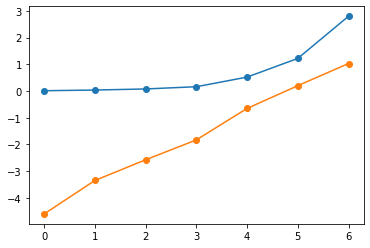

In [6]:
# z values from Pelletier & Field (2016)
zs = np.array([0.01, 0.035, 0.076, 0.16, 0.52, 1.22, 2.8]) # m
plt.plot(zs, marker='o')
plt.plot(np.log(zs), marker='o')

# Roughly logarithmic spacing
print(zs[1:]/zs[0:-1])

In [62]:
def calc_zstar_from_slope_and_intercept(z0, slope, intercept):
    return z0*np.exp(-intercept/slope)

def calc_analytic_ustar(kappa, x, y, sigma):
    return kappa*calc_slope(x, y, sigma)

def calc_analytic_zstar(z0, x, y, sigma):
    slope = calc_slope(x, y, sigma)
    intercept = calc_intercept(x, y, sigma)
    
    return calc_zstar_from_slope_and_intercept(z0, slope, intercept)

def calc_analytic_sigma_ustar(kappa, delta_x, sigma, N):
    return kappa*calc_analytic_sigma_slope(delta_x, sigma, N)

def calc_analytic_sigma_zstar(kappa, z0, delta_x, x, y, sigma):
    N = len(x)
    
    ustar = calc_analytic_ustar(kappa, x, y, sigma)
    zstar = calc_analytic_zstar(z0, x, y, sigma)
    intercept = calc_intercept(x, y, sigma)
    
    sigma_intercept = calc_analytic_sigma_intercept(sigma[0], N)
    sigma_ustar = calc_analytic_sigma_ustar(kappa, delta_x, sigma[0], N)
    
    return np.sqrt(sigma_intercept**2/ustar**2 - intercept**2*sigma_ustar**2)*kappa*zstar

zs = np.array([0.01, 0.035, 0.076, 0.16, 0.52, 1.22, 2.8]) # m
z0 = zs[0]
kappa = 0.4

# print(calc_slope(x, noisy_y, sigma), calc_intercept(x, noisy_y, sigma))
# print(calc_analytic_sigma_slope(delta_x, sigma[0], num_sensors), 
#       calc_analytic_sigma_intercept(sigma[0], num_sensors))
print(calc_analytic_ustar(kappa, x, y, sigma), calc_analytic_zstar(z0, x, y, sigma))
print(calc_analytic_ustar(kappa, x, noisy_y, sigma), calc_analytic_zstar(z0, x, noisy_y, sigma))
print(calc_analytic_sigma_ustar(kappa, delta_x, sigma[0], num_sensors), 
      calc_analytic_sigma_zstar(kappa, z0, delta_x, x, y, sigma))

print((calc_analytic_zstar(z0, x, y, sigma) - calc_analytic_zstar(z0, x, noisy_y, sigma))/\
      calc_analytic_sigma_zstar(kappa, z0, delta_x, x, y, sigma))

4.000000000000002 0.009048374180359616
3.9997301615109198 0.01310107410297406
0.316227766016838 0.0033122487967006727
-1.22354936822721
